In [1]:
# Data are from the Socorro USHCN site (298387)
# UHCN data browser is at http://cdiac.ornl.gov/epubs/ndp/ushcn/ushcn_map_interface.html
# data link: http://cdiac.ornl.gov/cgi-bin/broker?_PROGRAM=prog.climsite_monthly.sas&_SERVICE=default&id=298387&_DEBUG=0

# See the SPEI Socorro notebook
library('readr')
library('dplyr')
library('ggplot2')
library('forecast')
library('repr')

fname <- 'SPEI_out/socorro_1900_spei.csv'

df <- read_csv(fname)
head(df)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Parsed with column specification:
cols(
  Date = col_character(),
  cwdiff = col_double(),
  spei6mo = col_double(),
  spei12mo = col_double(),
  spei6mo_5Ymean = col_double(),
  spei6mo_adj5Ymean = col_double(),
  spei6mo_5Ysd = col_double(),
  spei6mo_adj5Ysd = col_double(),
  spei6mo_adj5Ycv = col_double()
)


Date,cwdiff,spei6mo,spei12mo,spei6mo_5Ymean,spei6mo_adj5Ymean,spei6mo_5Ysd,spei6mo_adj5Ysd,spei6mo_adj5Ycv
Jan 1900,33.901450,NA,NA,NA,NA,NA,NA,NA
Feb 1900,10.015018,NA,NA,NA,NA,NA,NA,NA
Mar 1900,-4.887078,NA,NA,NA,NA,NA,NA,NA
Apr 1900,-22.734462,NA,NA,NA,NA,NA,NA,NA
May 1900,-70.529805,NA,NA,NA,NA,NA,NA,NA
Jun 1900,-121.886952,0.9030355,NA,NA,NA,NA,NA,NA


# Forecast climatic water differential

In [2]:
# Make a timeseries
cwdiff <- ts(df$cwdiff[1:length(df$cwdiff)], frequency=12, start=c(1900, 1))

## Check for seasonal lags and autocorrelation

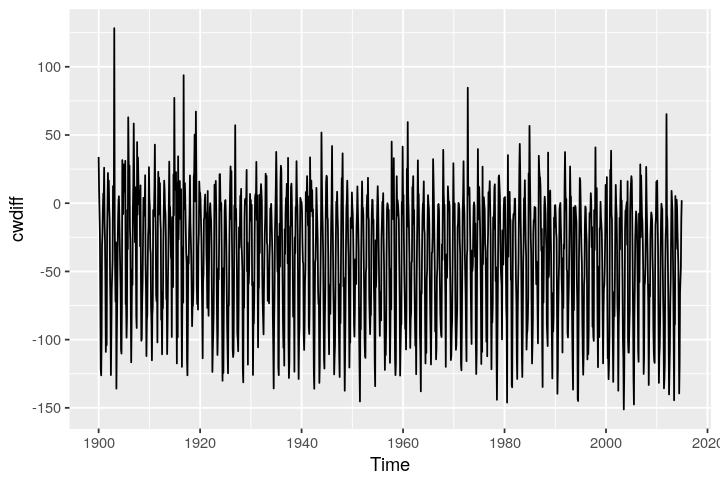

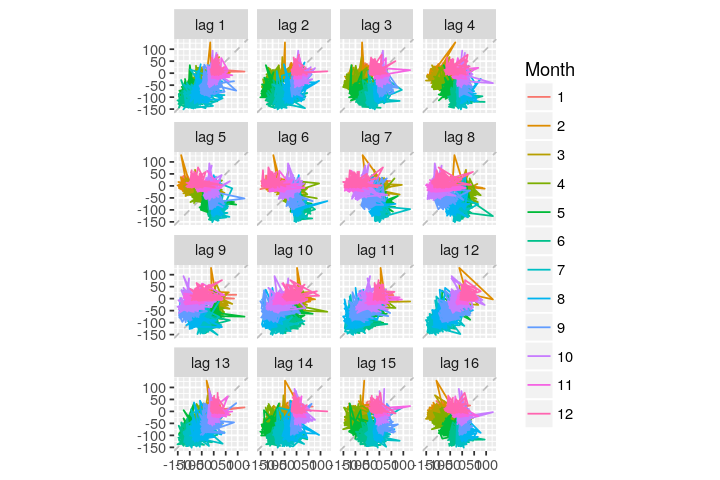

In [3]:
options(repr.plot.width=6, repr.plot.height=4)
autoplot(cwdiff)
gglagplot(cwdiff)
# There is some autocorrelation at lags 1-2 and at 12 (evidence of seasonality)

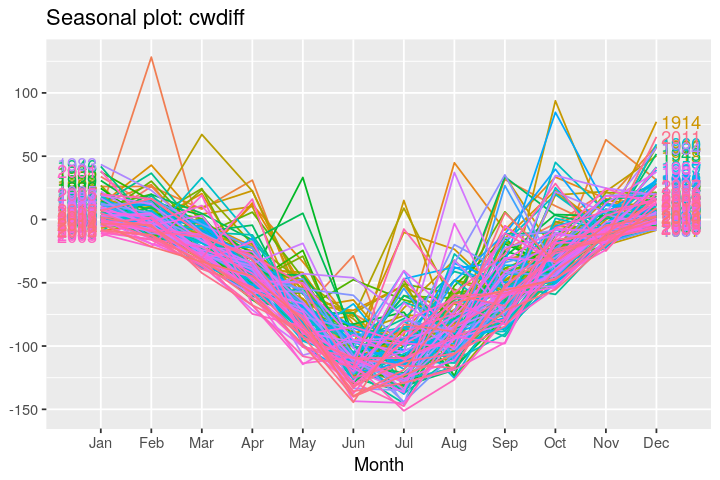

In [4]:
ggseasonplot(cwdiff, year.labels=TRUE, year.labels.left=TRUE)
# Its seasonal!

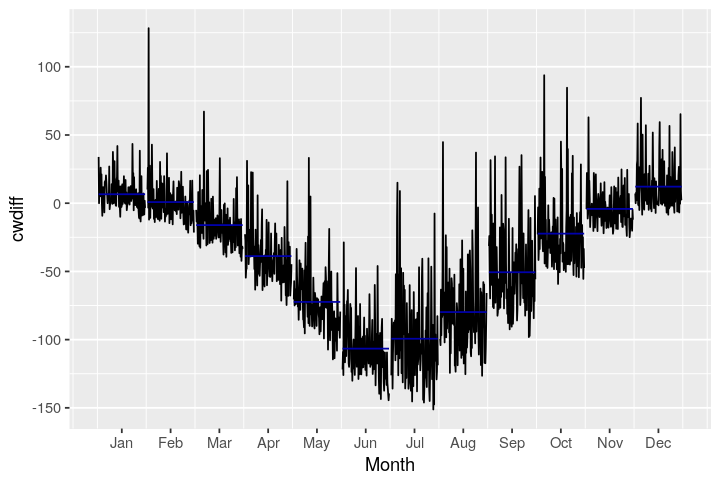

In [5]:
ggsubseriesplot(cwdiff)
# Again - seasonality, but definitely the spei trend varies by month (most negative in spring and October)

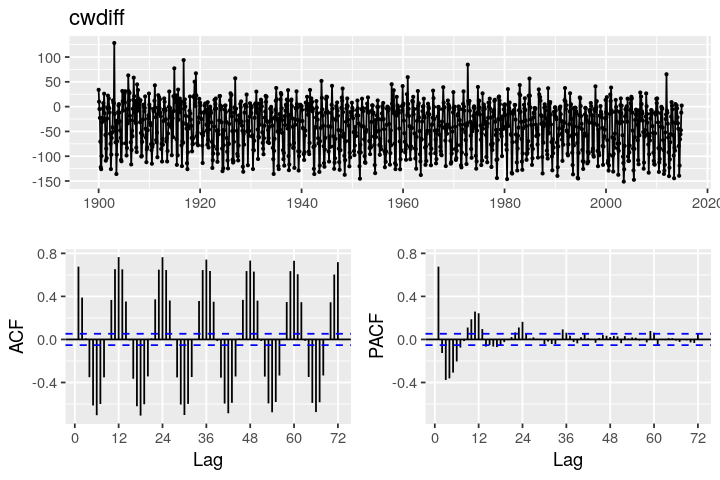

In [6]:
ggtsdisplay(cwdiff, lag=72)
# Strong autocorrelation for first 2 months (or more?), 12 month seasonality, then a trend (slowly declining acf)

Warning message in adf.test(cwdiff, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  cwdiff
Dickey-Fuller = -7.667, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


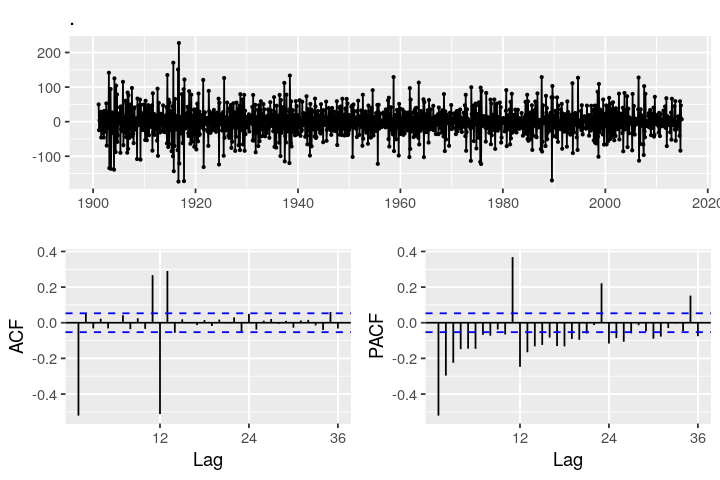

In [7]:
# PRetty clear the timeseries is not stationary. Check ADF test
# and the effect of differencing
library('tseries')
adf.test(cwdiff, alternative = "stationary")
cwdiff %>% diff() %>% diff(lag=12) %>% ggtsdisplay

# One diff makes timeseries appear stationary, but according to
# ADF test it already is... Tested some ARIMAs below and using a differencing
# in the model (middle order > 0) does not seem good
# But there is still autocorrelation (peak at lag 6)

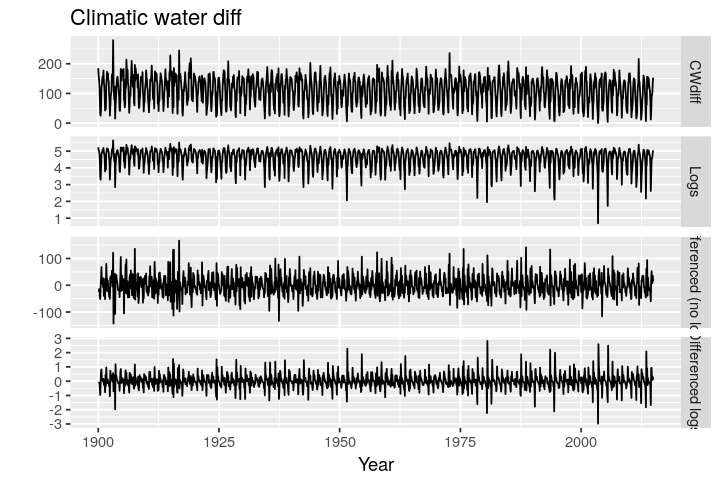

In [8]:
cwd <- cwdiff
cbind("CWdiff" = cwd - min(cwd),
      "Logs" = log(cwd - min(cwd) + 2),
      "Differenced (no log)" = diff(cwd),
      "Differenced logs" = diff(log(cwd - min(cwd) + 2))) %>%
  autoplot(facets=TRUE) +
    xlab("Year") + ylab("") +
    ggtitle('Climatic water diff')

## Try some ARIMA fits


	Ljung-Box test

data:  residuals
Q* = 68.28, df = 17, p-value = 4.256e-08

Model df: 7.   Total lags used: 24



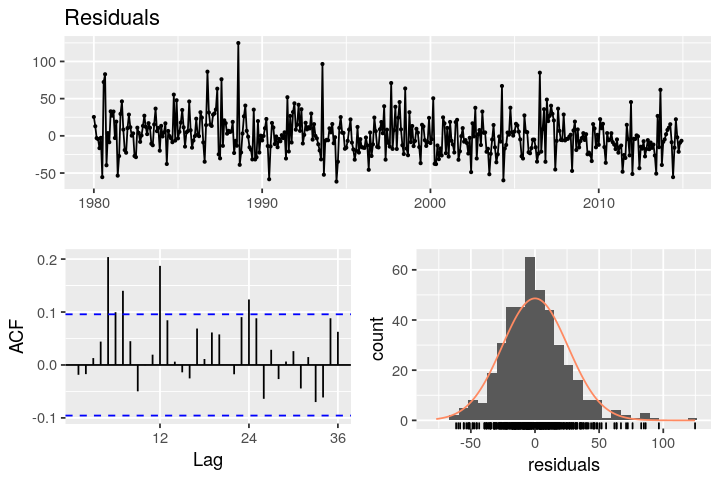

In [9]:
fit0 <- auto.arima(window(cwdiff, start=1980), seasonal=FALSE)
checkresiduals(fit0)
# Not so good

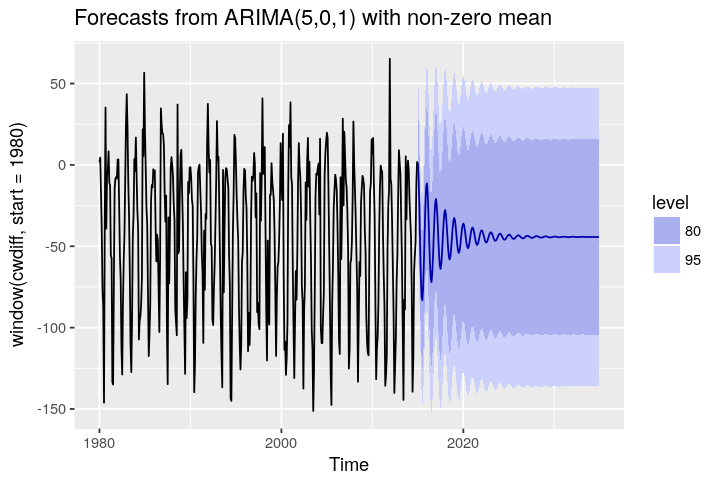

In [10]:
fit0 %>% forecast(h=12*20) %>% autoplot()


	Ljung-Box test

data:  residuals
Q* = 39.655, df = 15, p-value = 0.0005112

Model df: 9.   Total lags used: 24



[1] 5702.629

[1] 5552.233

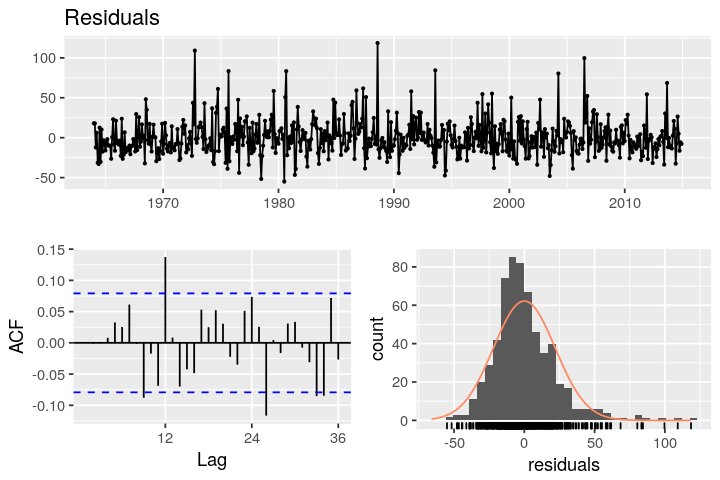

In [11]:
styr <- 1964
fit1 <- Arima(window(cwdiff, start=styr), order=c(5,0,2), include.drift=TRUE)
checkresiduals(fit1)

# 5,0,1 fits OK, but increasing the MA parameter to 5,0,2 leads to residuals that are uncorrelated
# (p>0.05, still a high Q*). AIC improves too. Residuals don't seem perfectly normal though...
AIC(Arima(window(cwdiff, start=styr), order=c(5,0,1), include.drift=TRUE))
AIC(Arima(window(cwdiff, start=styr), order=c(5,0,2), include.drift=TRUE))

## Best non-seasonal ARIMA model

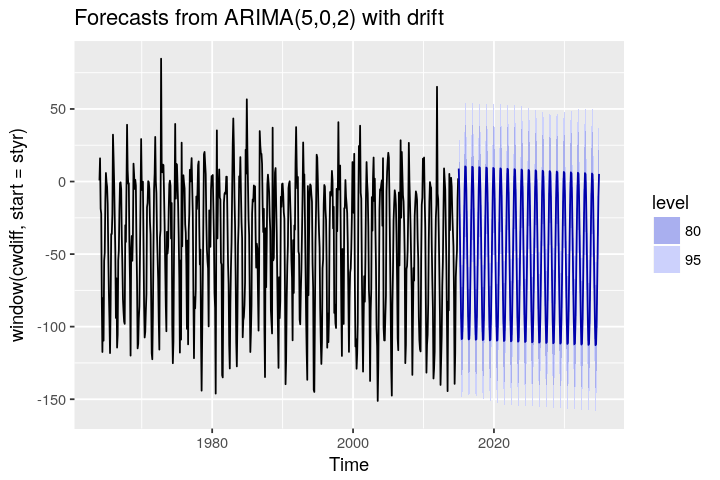

In [12]:
fit1 %>% forecast(h=240) %>% autoplot

## Climatic water diff forecast (non-seasonal model)

ar1          ar2          ar3          ar4          ar5          ma1 
  1.86260345  -1.22976466   0.15591883  -0.03667731   0.01914114  -1.74301147 
         ma2    intercept        drift 
  0.99986800 -36.26920953  -0.02060138

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last



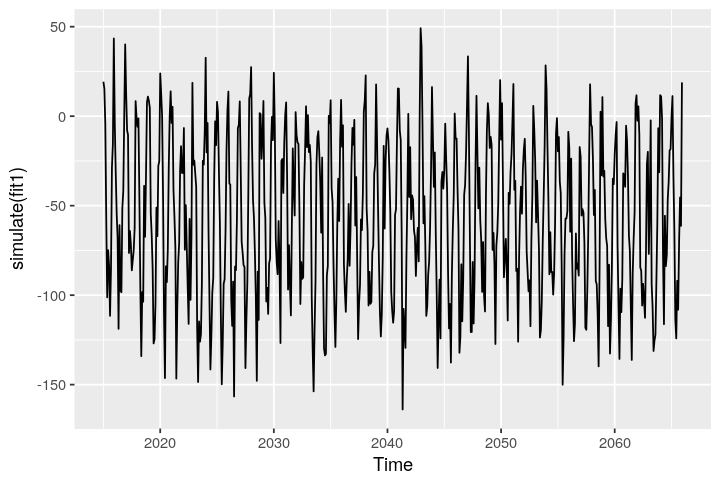

In [13]:
coef(fit1)

# This is the automatic way with forecast (which I think calls arima.sim but it must do it better than me)
library('TeachingDemos')
char2seed('csf5', set=TRUE) # gremau, csf3, csf5
autoplot(simulate(fit1))

library('xts')
# This should get us out to 2070
nsimlen <- length(window(cwdiff, start=styr))+(21*12)
sim <- as.xts(simulate(fit1, nsim=nsimlen))
write.zoo(sim, 'cwdiff_sim.csv')

In [14]:
confint(fit1)

,2.5 %,97.5 %
ar1,1.78289216,1.94231474
ar2,-1.39733620,-1.06219313
ar3,-0.03736753,0.34920519
ar4,-0.20450007,0.13114544
ar5,-0.06118582,0.09946810
ma1,-1.75921887,-1.72680406
ma2,0.98303543,1.01670057
intercept,-40.18105845,-32.35736061
drift,-0.03165781,-0.00954494


In [15]:
# Create dataframe from simulation
sim2 <- data.frame(Date=time(sim), cwdiff=sim, check.names=FALSE, row.names=NULL)
sim2$Date <- as.character(sim2$Date)
# Bind it to the original dataframe
library('dplyr')
new <- bind_rows(df, sim2)
tail(new)

Date,cwdiff,spei6mo,spei12mo,spei6mo_5Ymean,spei6mo_adj5Ymean,spei6mo_5Ysd,spei6mo_adj5Ysd,spei6mo_adj5Ycv
Jul 2086,-153.67600,NA,NA,NA,NA,NA,NA,NA
Aug 2086,-176.84228,NA,NA,NA,NA,NA,NA,NA
Sep 2086,-63.89052,NA,NA,NA,NA,NA,NA,NA
Oct 2086,-56.60813,NA,NA,NA,NA,NA,NA,NA
Nov 2086,-39.16085,NA,NA,NA,NA,NA,NA,NA
Dec 2086,-18.61632,NA,NA,NA,NA,NA,NA,NA


## Forecasted SPEI

 Time-Series [1:1380] from 1900 to 2015: 33.9 10.02 -4.89 -22.73 -70.53 ...
An ‘xts’ object on Jan 2015/Dec 2086 containing:
  Data: num [1:864, 1] 28.34 -3.18 -57.71 -52.41 -65.32 ...
  Indexed by objects of class: [yearmon] TZ: 
  xts Attributes:  
 NULL


Date,cwdiff,spei6mo,spei12mo,spei6mo_5Ymean,spei6mo_adj5Ymean,spei6mo_5Ysd,spei6mo_adj5Ysd,spei6mo_adj5Ycv,spei6mo_fc
Jan 1900,33.901450,NA,NA,NA,NA,NA,NA,NA,NA
Feb 1900,10.015018,NA,NA,NA,NA,NA,NA,NA,NA
Mar 1900,-4.887078,NA,NA,NA,NA,NA,NA,NA,NA
Apr 1900,-22.734462,NA,NA,NA,NA,NA,NA,NA,NA
May 1900,-70.529805,NA,NA,NA,NA,NA,NA,NA,NA
Jun 1900,-121.886952,0.9030355,NA,NA,NA,NA,NA,NA,1.139662


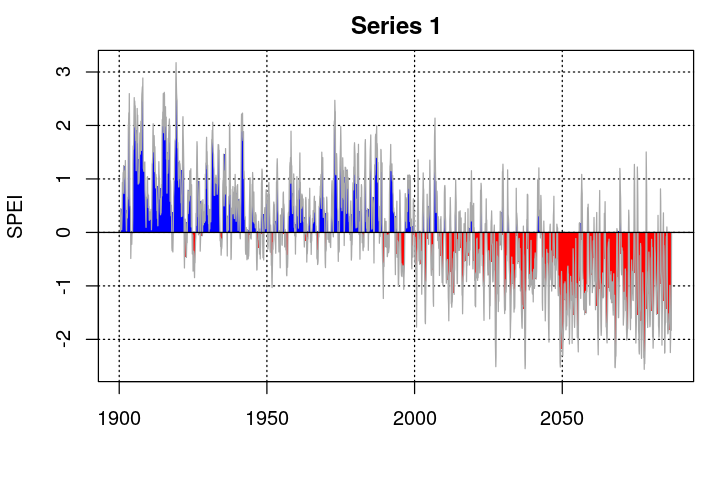

In [17]:
# Put together cwdiff and forecast and calculate spei
# Get spei tools
source('~/current/GitHub/climate_tools/spei.r')

str(cwdiff)
str(sim)

cwd_fc <- rbind(as.xts(cwdiff), sim)
spei_fc <- get_spei(cwd_fc)

new$spei6mo_fc <- xts(as.vector(spei_fc$fitted),  order.by=index(cwd_fc))

head(new)

outfile <- 'socorro_1900_to_2070_spei'
#write.zoo(new, file = paste('output_data/Sev_SPEI/', outfile, '.csv', sep=''),
#          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)
#write.table(as.data.frame(new), file = paste('SPEI_out/', outfile, '.csv', sep=''), sep=',', row.names = FALSE, col.names=TRUE)

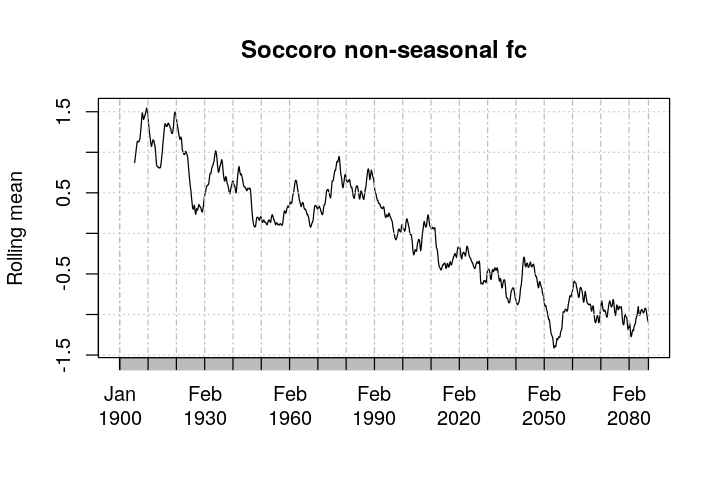

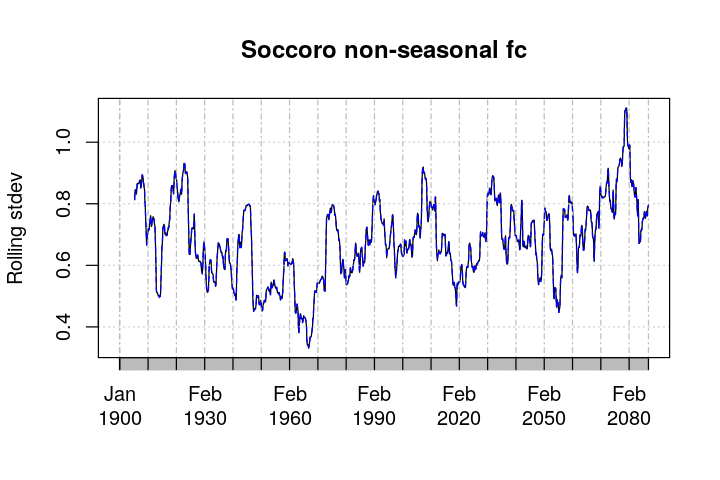

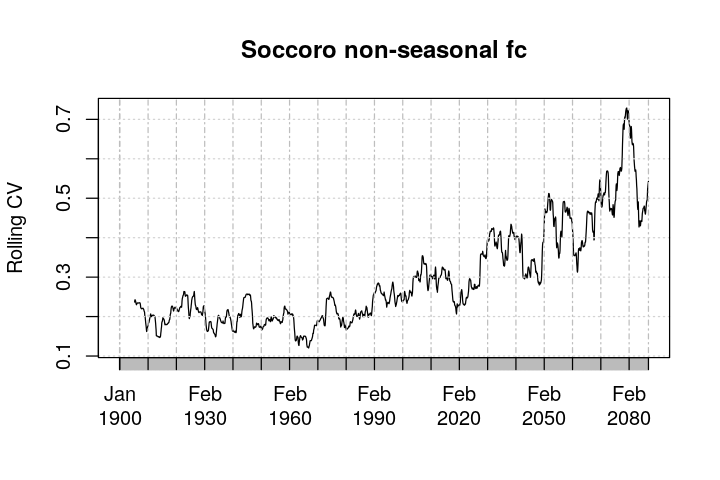

In [19]:
# 5 year rolling CV calculation
source('~/current/GitHub/climate_tools/ts_variability_trends.r')
cv <- get_rolling_CV(new$spei6mo_fc, 5*12, positivize=TRUE, plots=TRUE, site='Soccoro non-seasonal fc')

On the positive side, CV is increasing steadily in the forecasted data. This means we have forecasted increasing variance. However, I am beginning to suspect this is mostly because the mean is decreasing. Std Dev is not changing (or is even declining).

## Seasonal forecast model


	Ljung-Box test

data:  residuals
Q* = 148.76, df = 21, p-value < 2.2e-16

Model df: 3.   Total lags used: 24



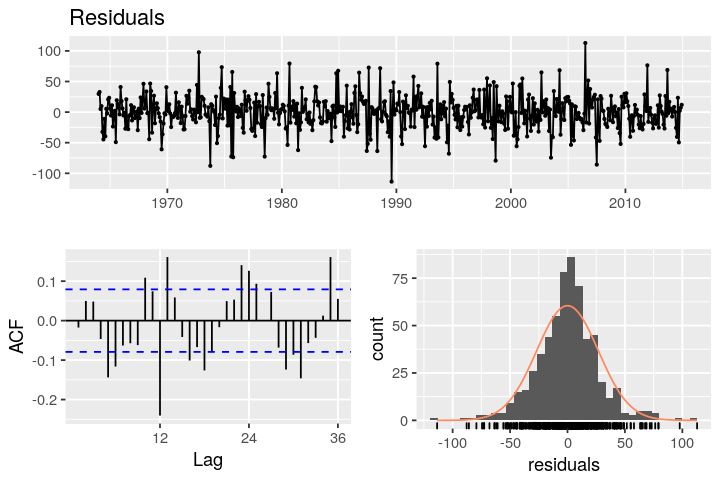

In [21]:
styr=1964
fit0 <- auto.arima(window(cwdiff, start=styr), seasonal=TRUE, allowdrift=TRUE)
checkresiduals(fit0)

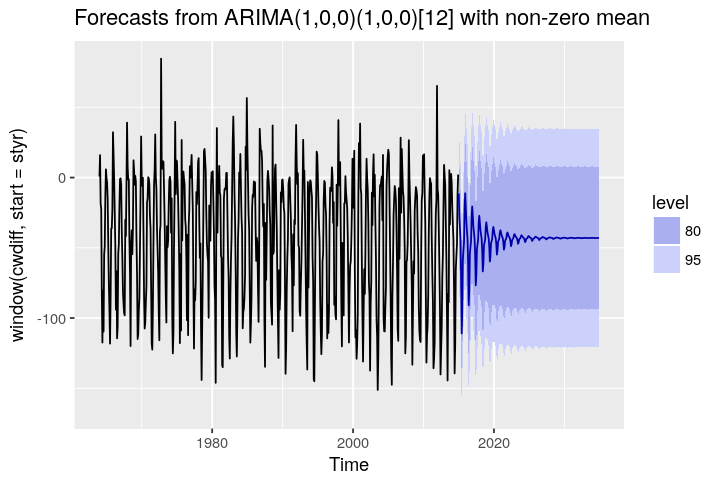

In [22]:
fit0 %>% forecast(h=12*20) %>% autoplot()

In [23]:
styr<-1964
# Non-seasonal model (see above)
AIC(Arima(window(cwdiff, start=styr), order=c(5,0,2), include.drift=TRUE))
# Bunch of seasonal trials, last one chosen
AIC(Arima(window(cwdiff, start=styr), order=c(1,0,0), seasonal=c(1,0,0), include.drift=TRUE))
AIC(Arima(window(cwdiff, start=styr), order=c(0,1,1), seasonal=c(0,1,1), include.drift=TRUE))
AIC(Arima(window(cwdiff, start=styr), order=c(0,0,1), seasonal=c(0,1,2), include.drift=TRUE))
AIC(Arima(window(cwdiff, start=styr), order=c(1,0,1), seasonal=c(0,1,2), include.drift=TRUE))

[1] 5552.233

[1] 5782.458

Warning message in Arima(window(cwdiff, start = styr), order = c(0, 1, 1), seasonal = c(0, :
“No drift term fitted as the order of difference is 2 or more.”

[1] 5421.604

[1] 5416.382

[1] 5415.535


	Ljung-Box test

data:  residuals
Q* = 19.744, df = 19, p-value = 0.4101

Model df: 5.   Total lags used: 24



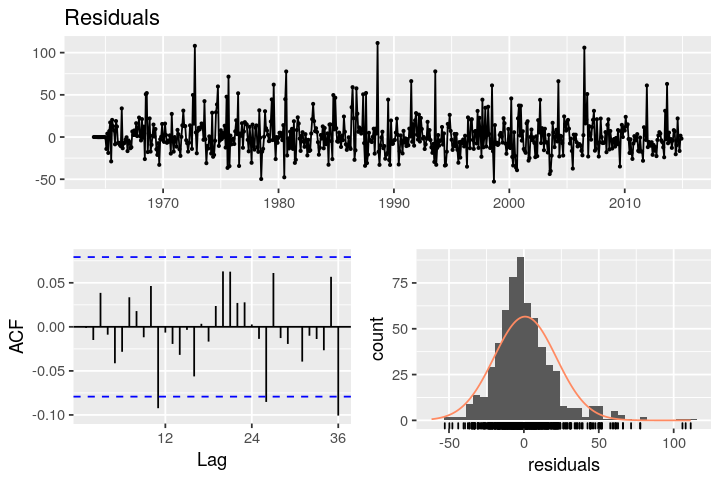

In [24]:
fit1 <- Arima(window(cwdiff, start=styr), order=c(1,0,1), seasonal=c(0,1,2), include.drift=TRUE)
checkresiduals(fit1)
# There are still some correlations at 11, 26 and 36. Not sure what these are or how to improve
# the model to fit them. For now this does a good job, and better than the non-seasonal model
# (See AICs above)

## USING THIS FORECAST MODEL (for now)

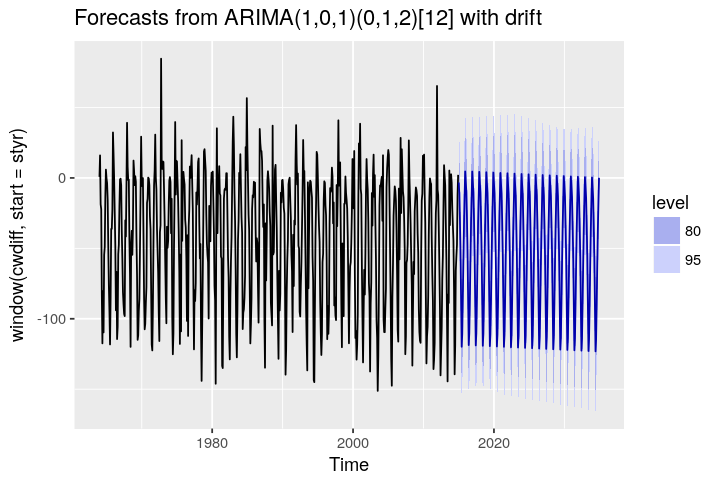

In [25]:
fit1 %>% forecast(h=240) %>% autoplot

## Climatic water diff forecast (seasonal model)

ar1         ma1        sma1        sma2       drift 
 0.60722405 -0.50910473 -0.92817554 -0.07178782 -0.02064570

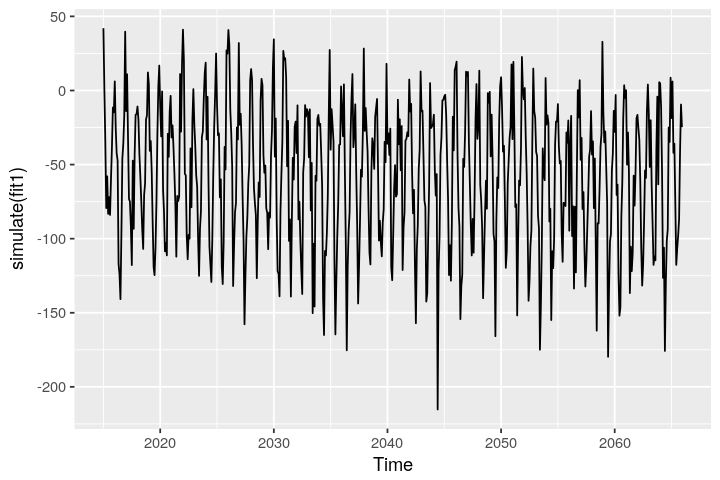

In [40]:
coef(fit1)

# This is the automatic way with forecast (which I think calls arima.sim but it must do it better than me)
library('TeachingDemos')
char2seed('csf2', set=TRUE) # gremau, csf3 used in earlier iterations, csf5
autoplot(simulate(fit1))

library('xts')
# This should get us out to 2070
nsimlen <- length(window(cwdiff, start=styr))+(5*12)
sim <- as.xts(simulate(fit1, nsim=nsimlen))
write.zoo(sim, 'cwdiff_sim.csv')

In [41]:
# Create dataframe from simulation
sim2 <- data.frame(Date=time(sim), cwdiff=sim, check.names=FALSE, row.names=NULL)
sim2$Date <- as.character(sim2$Date)
# Bind it to the original dataframe
library('dplyr')
new <- bind_rows(df, sim2)
tail(new)

Date,cwdiff,spei6mo,spei12mo,spei6mo_5Ymean,spei6mo_adj5Ymean,spei6mo_5Ysd,spei6mo_adj5Ysd,spei6mo_adj5Ycv
Jul 2070,-150.37486,NA,NA,NA,NA,NA,NA,NA
Aug 2070,-144.84504,NA,NA,NA,NA,NA,NA,NA
Sep 2070,-71.78421,NA,NA,NA,NA,NA,NA,NA
Oct 2070,-53.36377,NA,NA,NA,NA,NA,NA,NA
Nov 2070,-44.44271,NA,NA,NA,NA,NA,NA,NA
Dec 2070,-3.48354,NA,NA,NA,NA,NA,NA,NA


## Forecasted SPEI

 Time-Series [1:1380] from 1900 to 2015: 33.9 10.02 -4.89 -22.73 -70.53 ...
An ‘xts’ object on Jan 2015/Dec 2070 containing:
  Data: num [1:672, 1] 18.16 2.27 -76.16 -39.29 -50.48 ...
  Indexed by objects of class: [yearmon] TZ: 
  xts Attributes:  
 NULL


Date,cwdiff,spei6mo,spei12mo,spei6mo_5Ymean,spei6mo_adj5Ymean,spei6mo_5Ysd,spei6mo_adj5Ysd,spei6mo_adj5Ycv,spei6mo_fc
Jan 1900,33.901450,NA,NA,NA,NA,NA,NA,NA,NA
Feb 1900,10.015018,NA,NA,NA,NA,NA,NA,NA,NA
Mar 1900,-4.887078,NA,NA,NA,NA,NA,NA,NA,NA
Apr 1900,-22.734462,NA,NA,NA,NA,NA,NA,NA,NA
May 1900,-70.529805,NA,NA,NA,NA,NA,NA,NA,NA
Jun 1900,-121.886952,0.9030355,NA,NA,NA,NA,NA,NA,1.091009


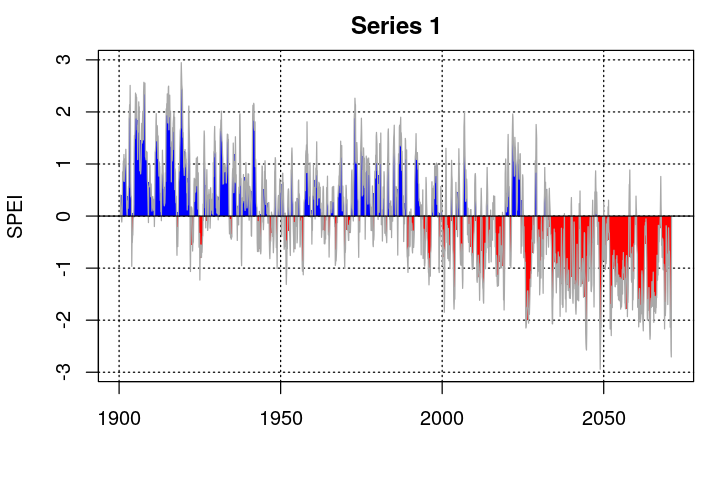

In [42]:
# Put together cwdiff and forecast and calculate spei
# Get spei tools
source('~/current/GitHub/climate_tools/spei.r')

str(cwdiff)
str(sim)
# Confidence intervals
fcst_len <- 12*(2070-2014)
fcst <- forecast(fit1, h=(fcst_len))
lower80 <- as.xts(fcst$lower[,1])
lower95 <- as.xts(fcst$lower[,2])
upper80 <- as.xts(fcst$upper[,1])
upper95 <- as.xts(fcst$upper[,2])


#cnames <- c('spei6mo_fc', 'spei6mo_fc_lower95', 'spei6mo_fc_lower80',
#            'spei6mo_fc_upper80', 'spei6mo_fc_upper95')
#i <- 1
#for (s in cnames){
#    cwd_fc <- rbind(as.xts(cwdiff), s)
#    spei_fc <- get_spei(cwd_fc)
#    len <- length(spei_fc)
#    st <- len - (i*fcst_len)
#    ed <- len - ((i-1)*fcst_len)
#    new[cnames[i]] <- spei_fc[st:ed]
#    i <- i + 1
#}

cwd_fc <- rbind(as.xts(cwdiff), sim)#, upper95, upper80, lower80, lower95)
spei_fc <- get_spei(cwd_fc)
new$spei6mo_fc <- xts(as.vector(spei_fc$fitted),  order.by=index(cwd_fc))
head(new)

outfile <- 'socorro_1900_to_2070_spei'
#write.zoo(new, file = paste('output_data/Sev_SPEI/', outfile, '.csv', sep=''),
#          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)
write.table(as.data.frame(new), file = paste('SPEI_out/', outfile, '.csv', sep=''), sep=',', row.names = FALSE, col.names=TRUE)

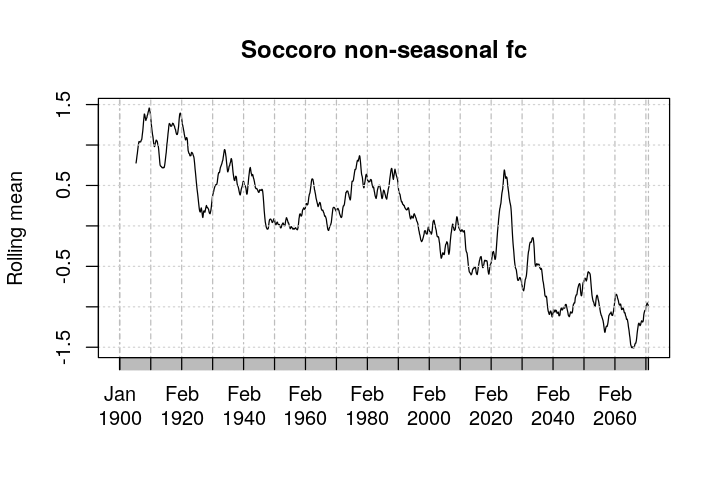

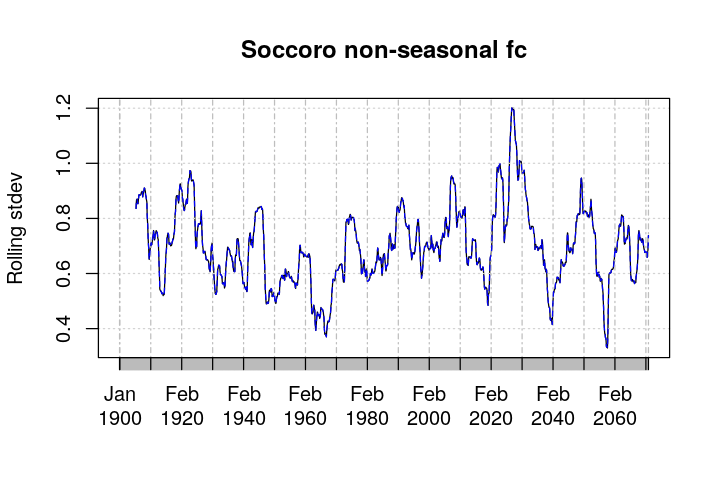

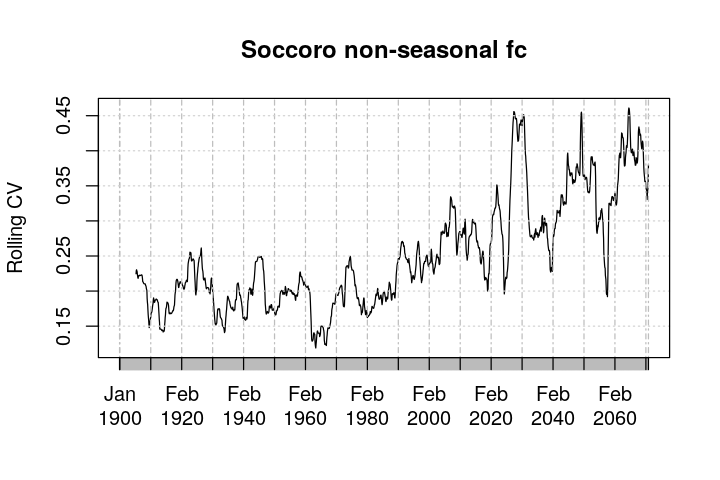

In [43]:
# 5 year rolling CV calculation
source('~/current/GitHub/climate_tools/ts_variability_trends.r')
cv <- get_rolling_CV(new$spei6mo_fc, 12*5, positivize=TRUE, plots=TRUE, site='Soccoro non-seasonal fc')